In [1]:
import pandas as pd
import numpy as np

np.random.seed(seed=17)

import sys
import warnings
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [3]:
PATH_TO_DATA = "./"

X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

In [4]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


In [5]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(C=1, solver='liblinear')
cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

In [6]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
from IPython.display import display_html

In [8]:
import eli5

eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.221,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.148,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [9]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [10]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91807

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

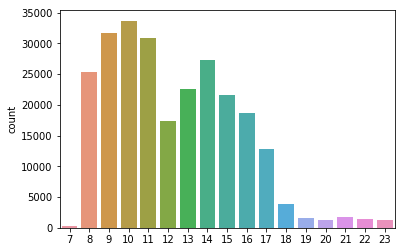

In [12]:
sns.countplot(session_start_hour)

Text(0.5, 0, 'Session start hour')

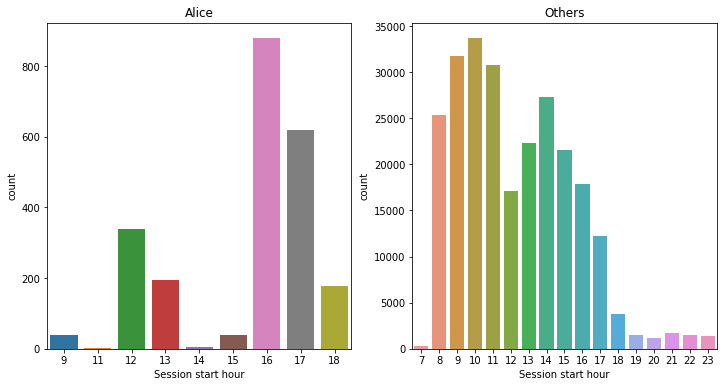

In [13]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour')

In [14]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [15]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

In [16]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [18]:
%%time
from scipy.sparse import hstack
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

Wall time: 2.03 s


In [19]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50005), (82797, 50005))

In [21]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [22]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

CV scores [0.81904687 0.78705941 0.94510729 0.96676436 0.88993626 0.96695873
 0.9182761  0.93962258 0.96595914 0.96884529]
CV mean: 0.9167576033725782, CV std: 0.062106327535212884


Weight?,Feature
+7.046,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.987,www.express.co.uk
+4.833,youwatch.org
+4.803,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


New feature weights:
   feature      coef
0  morning -2.904808
1      day -0.613780
2  evening -5.069846
3    night  0.000000
4     hour  7.045554
